In [76]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier

In [77]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [78]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
config = AutoConfig.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                    num_labels=5, 
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1, return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                                           config=config,
                                                           ignore_mismatched_sizes=True)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
data = pd.read_csv("../data/train_data.csv")
data["label"] = data["rating"]
data.rename(columns={"review":"text"}, inplace=True)
data.drop('rating', axis=1, inplace=True)
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
print(data)

                                                    text  label
0      location not palace excellent hotel booke dthe...      4
1      respite definitely not place stay looking ultr...      3
2      stunning truly memorable spot right beach nusa...      4
3      solid business hotel near embassy stayed hotel...      3
4      nice place make sure lock money warning money ...      3
...                                                  ...    ...
16387  great base explore new york stayed 4 nights en...      4
16388  wonderful advert paris wonderful introduction ...      4
16389  ideal relaxing holdiay rachel jay green liverp...      3
16390  watch food, husband went resort 4 nights chris...      2
16391  fantastic hotel central barcelona family just ...      4

[16392 rows x 2 columns]


In [80]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

In [81]:
mca_eval = MulticlassAccuracy(num_classes=5, average=None)
mca_average = MulticlassAccuracy(num_classes=5, average='micro')

In [82]:
def create_data_loader(encodings, labels):
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels.values))
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    return loader

In [83]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [84]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [85]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            # max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)
        }

In [86]:
train_dataset = ReviewDataset(
    reviews=train_data['text'].to_numpy(),
    targets=train_data['label'].to_numpy(),
    tokenizer=tokenizer,
)

test_dataset = ReviewDataset(
    reviews=val_data['text'].to_numpy(),
    targets=val_data['label'].to_numpy(),
    tokenizer=tokenizer,
)


In [87]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"results_{now}"
training_args = TrainingArguments(
    output_dir=f"../models/{output_dir}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [88]:
loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.4, 1.2, 0.5, 0.3]))

In [89]:
class CustomTrainer(Trainer):
    def __init__(self, loss_fn=loss_function, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Tradycyjne podejście bez walidacji krzyzowej

In [90]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.747601,0.666463,0.598759,0.625800,0.589862
2,0.883300,0.732062,0.687195,0.624156,0.634572,0.616874
3,0.714600,0.739012,0.672561,0.621032,0.625572,0.618072
4,0.639100,0.779756,0.680488,0.626475,0.642864,0.616403
5,0.570700,0.845500,0.656707,0.597883,0.591394,0.605435
6,0.504000,0.895621,0.665854,0.609498,0.615835,0.605931
7,0.444200,0.945642,0.660976,0.624669,0.640519,0.613452
8,0.392700,1.002218,0.642073,0.592228,0.592232,0.593717
9,0.346500,1.033306,0.649390,0.607463,0.612535,0.603725
10,0.321600,1.051750,0.653049,0.608703,0.615294,0.603614


TrainOutput(global_step=4610, training_loss=0.530019964520171, metrics={'train_runtime': 1035.9358, 'train_samples_per_second': 142.403, 'train_steps_per_second': 4.45, 'total_flos': 1.95426361393152e+16, 'train_loss': 0.530019964520171, 'epoch': 10.0})

In [15]:
# model_eval = AutoModelForSequenceClassification.from_pretrained(f"../models/{output_dir}")
# eval_trainer = Trainer(model=model)

OSError: ../models/./results_2024-06-16_11-42-29 does not appear to have a file named config.json. Checkout 'https://huggingface.co/../models/./results_2024-06-16_11-42-29/tree/None' for available files.

In [91]:
predictions = trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

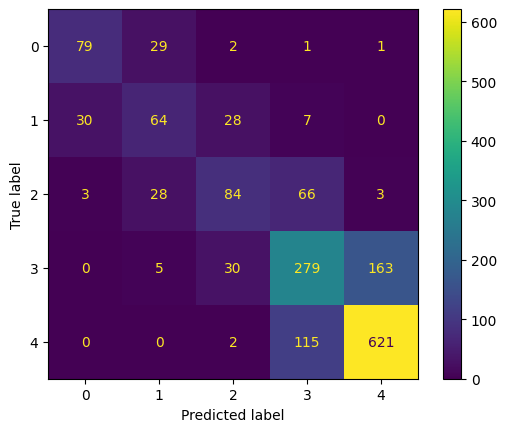

In [92]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [93]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

tensor([0.7054, 0.4961, 0.4565, 0.5849, 0.8415])

In [94]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

tensor(0.6872)

Model ma tendencje do przetrenowywania, więc naturalnym krokiem będzie dobranie odpowiedniej strategi niwelującej przetrenowanie. W naszym przypadku zastosujemy skrośną walidacje.

# Wagi dobrane ze względu na ilości i accuracy dla kazdej z klas

In [56]:
config = AutoConfig.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                    num_labels=5, 
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1, return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                                           config=config,
                                                           ignore_mismatched_sizes=True)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
loss_function = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.7, 1.2, 0.5, 0.3]).to(device))

In [58]:
training_args = TrainingArguments(
    output_dir=f"../models/{output_dir}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    
)
loss_modified_trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        loss_fn = loss_function
)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
loss_modified_trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [46]:
predictions = loss_modified_trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

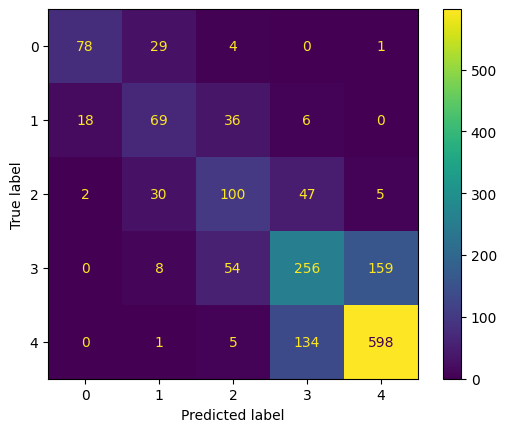

In [47]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [48]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

tensor([0.6964, 0.5349, 0.5435, 0.5367, 0.8103])

In [49]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

tensor(0.6713)

# Rozkład według ilości klas w zbiorze

In [60]:
config = AutoConfig.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                    num_labels=5, 
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1, return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                                           config=config,
                                                           ignore_mismatched_sizes=True)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
unique_classes = np.unique(data["label"].values)
y = data["label"].values

In [62]:
class_weights = compute_class_weight(class_weight='balanced', classes = unique_classes, y = y)
class_weights = torch.tensor(class_weights).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights.to(torch.float32))

In [63]:
training_args = TrainingArguments(
    output_dir=f"../models/{output_dir}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    
)
loss_distribution_trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        loss_fn = loss_function
)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [64]:
loss_distribution_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.890077,0.638415,0.581348,0.568395,0.607017
2,1.005500,0.882662,0.639024,0.594527,0.582708,0.609481
3,0.806700,0.879234,0.650610,0.612691,0.607091,0.626942
4,0.704900,0.970423,0.664024,0.629566,0.632732,0.637850
5,0.607400,1.019514,0.657317,0.609843,0.595953,0.629184
6,0.512000,1.135569,0.671341,0.633066,0.640428,0.634545
7,0.449600,1.250666,0.632927,0.612658,0.612537,0.626435
8,0.386200,1.292830,0.647561,0.618729,0.609506,0.633831
9,0.343700,1.499364,0.670122,0.619048,0.631327,0.609470
10,0.305800,1.522177,0.670732,0.625497,0.632884,0.623369


TrainOutput(global_step=6915, training_loss=0.4511134933063455, metrics={'train_runtime': 1561.1964, 'train_samples_per_second': 141.737, 'train_steps_per_second': 4.429, 'total_flos': 2.93139542089728e+16, 'train_loss': 0.4511134933063455, 'epoch': 15.0})

In [ ]:
predictions = loss_distribution_trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

In [ ]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [ ]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

In [ ]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

# Walidacja skrośna

In [14]:
n_splits = 10
kf = KFold(n_splits=n_splits)

reviews = train_data['text'].to_numpy()
targets = train_data['label'].to_numpy()

In [15]:
for train_index, val_index in kf.split(reviews):
    train_reviews, val_reviews = reviews[train_index], reviews[val_index]
    train_targets, val_targets = targets[train_index], targets[val_index]

    train_dataset = ReviewDataset(train_reviews, train_targets, tokenizer, 128)
    val_dataset = ReviewDataset(val_reviews, val_targets, tokenizer, 128)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.805672,0.647696,0.575965,0.583624,0.578070
2,0.857400,0.782911,0.660569,0.597669,0.615448,0.591337
3,0.712000,0.783300,0.668699,0.592128,0.607585,0.587453
4,0.630900,0.794953,0.668699,0.610219,0.609189,0.611773
5,0.582600,0.805128,0.672087,0.606198,0.612250,0.603020


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.549952,0.765583,0.711007,0.709899,0.726720
2,0.569500,0.527761,0.772358,0.724946,0.739545,0.714292
3,0.455500,0.534189,0.790650,0.758230,0.765205,0.753987
4,0.388700,0.548305,0.790650,0.760653,0.764960,0.757225
5,0.366600,0.545580,0.789295,0.757801,0.763352,0.752834


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.348728,0.871186,0.868748,0.878196,0.860574
2,0.483700,0.358215,0.854915,0.849485,0.855168,0.847790
3,0.390300,0.358081,0.869831,0.861023,0.862961,0.860438
4,0.323500,0.354665,0.865085,0.857516,0.864430,0.851218
5,0.258800,0.353827,0.875254,0.871269,0.873888,0.869313


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.168454,0.943729,0.937055,0.928626,0.946808
2,0.218700,0.139871,0.947119,0.941280,0.945818,0.937376
3,0.176000,0.153678,0.952542,0.950456,0.954535,0.947482
4,0.135700,0.121471,0.960000,0.956687,0.959991,0.953786
5,0.133000,0.121851,0.960678,0.957756,0.959463,0.956515


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.104087,0.960000,0.961966,0.967207,0.959019
2,0.135700,0.051345,0.981017,0.977571,0.979747,0.975800
3,0.106100,0.089372,0.970169,0.973098,0.975023,0.972505
4,0.074000,0.025264,0.991864,0.994034,0.995522,0.992586
5,0.087600,0.018861,0.993220,0.994773,0.994630,0.994939


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.094406,0.966102,0.967037,0.972988,0.961675
2,0.118000,0.054872,0.985085,0.985141,0.987223,0.983130
3,0.093300,0.059220,0.983051,0.980229,0.984212,0.976653
4,0.053800,0.043497,0.990508,0.988435,0.987799,0.989184
5,0.059200,0.027694,0.991864,0.991063,0.990718,0.991422


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.040235,0.987119,0.986318,0.984143,0.988798
2,0.100700,0.052885,0.984407,0.986790,0.983087,0.990841
3,0.071000,0.041052,0.987119,0.985691,0.986089,0.985427
4,0.045600,0.043328,0.988475,0.986680,0.983207,0.990304
5,0.043900,0.017471,0.993898,0.992593,0.991459,0.993845


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.045160,0.987119,0.983594,0.982828,0.984477
2,0.115500,0.031962,0.988475,0.990291,0.989094,0.991567
3,0.053600,0.019188,0.993898,0.992187,0.993361,0.991165
4,0.035300,0.011188,0.996610,0.994610,0.994610,0.994610
5,0.035200,0.008845,0.997288,0.996257,0.996502,0.996029


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.068416,0.981695,0.983625,0.985628,0.982069
2,0.098300,0.032772,0.992542,0.992375,0.991132,0.993663
3,0.048200,0.027192,0.993220,0.991858,0.991038,0.992739
4,0.035100,0.023014,0.995932,0.995988,0.996020,0.995977
5,0.026800,0.018810,0.996610,0.997623,0.997838,0.997416


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.071473,0.980339,0.977182,0.976756,0.977951
2,0.084000,0.038516,0.986441,0.987414,0.990691,0.984470
3,0.056200,0.017780,0.993898,0.995108,0.994280,0.995956
4,0.035000,0.008918,0.997288,0.997114,0.997067,0.997184
5,0.021800,0.006926,0.997966,0.996156,0.995585,0.996789


In [25]:
predictions = trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

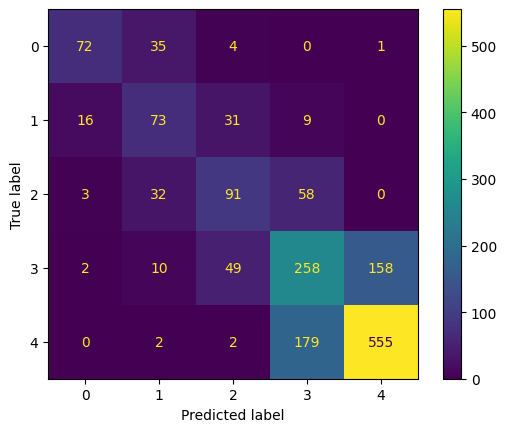

In [27]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [32]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

tensor([0.6429, 0.5659, 0.4946, 0.5409, 0.7520])

In [35]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

tensor(0.6396)

Walidacja skrośna pozwala na ograniczenie przetrenowania, ale w obecnej formie nie neguje problemów związanych z nierówną dystrybucją danych.

# Walidacja skrośna z wykorzystaniem podziału z równą dystrybucją klas w poszczególnych foldach i funkcji strat z wagami

In [103]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
config = AutoConfig.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                    num_labels=5, 
                                    hidden_dropout_prob=0.1,
                                    attention_probs_dropout_prob=0.1, return_dict=True)
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", 
                                                           config=config,
                                                           ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
unique_classes = np.unique(data["label"].values)
y = data["label"].values

In [105]:
class_weights = compute_class_weight(class_weight='balanced', classes = unique_classes, y = y)
class_weights = torch.tensor(class_weights).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights.to(torch.float32))

In [106]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_function(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [107]:
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits)

reviews = train_data['text'].to_numpy()
targets = train_data['label'].to_numpy()

In [108]:
for train_index, val_index in kf.split(reviews, targets):
    train_reviews, val_reviews = reviews[train_index], reviews[val_index]
    train_targets, val_targets = targets[train_index], targets[val_index]

    train_dataset = ReviewDataset(train_reviews, train_targets, tokenizer, 128)
    val_dataset = ReviewDataset(val_reviews, val_targets, tokenizer, 128)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.948584,0.586721,0.561723,0.552416,0.589404
2,1.006200,0.918168,0.615176,0.577807,0.572593,0.592146
3,0.802400,0.934260,0.638211,0.589312,0.581052,0.602880
4,0.691300,0.962359,0.615176,0.579376,0.565896,0.603173
5,0.621800,1.012782,0.636856,0.589002,0.580502,0.599839


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.714523,0.701897,0.673309,0.653342,0.711215
2,0.657300,0.641787,0.733740,0.731169,0.728078,0.743910
3,0.512900,0.690727,0.728997,0.719671,0.709340,0.737977
4,0.475500,0.693832,0.717480,0.706121,0.687922,0.730216
5,0.447600,0.694084,0.737805,0.739088,0.732423,0.747490


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.381207,0.797966,0.841894,0.833996,0.852244
2,0.522100,0.398222,0.788475,0.831246,0.818154,0.846861
3,0.425400,0.407574,0.792542,0.837203,0.840003,0.835478
4,0.366500,0.368789,0.803390,0.849560,0.840438,0.862066
5,0.312900,0.375866,0.797966,0.846515,0.835290,0.861880


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.248421,0.809492,0.877541,0.875329,0.896178
2,0.337600,0.254302,0.837288,0.887977,0.889642,0.892975
3,0.266700,0.219202,0.865085,0.909996,0.902953,0.917912
4,0.224300,0.223536,0.850169,0.900058,0.890141,0.914639
5,0.219000,0.224515,0.859661,0.906133,0.895997,0.919468


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.247880,0.877966,0.900632,0.906692,0.898294
2,0.232500,0.165193,0.888814,0.930672,0.930769,0.935991
3,0.180400,0.178006,0.897627,0.933990,0.935198,0.933975
4,0.155600,0.153761,0.901017,0.937721,0.933521,0.942733
5,0.179900,0.152943,0.899661,0.937111,0.935839,0.938638


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.110194,0.947119,0.966561,0.971305,0.963927
2,0.152700,0.108228,0.936949,0.958582,0.954380,0.964141
3,0.121000,0.114028,0.953220,0.969068,0.971092,0.967276
4,0.081100,0.091674,0.953220,0.969812,0.966794,0.973191
5,0.132900,0.080599,0.960678,0.975330,0.974287,0.976418


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.068279,0.961356,0.976461,0.974050,0.979683
2,0.108900,0.057291,0.974915,0.982777,0.983106,0.982625
3,0.074200,0.056928,0.972881,0.979937,0.976868,0.983442
4,0.050000,0.042160,0.979661,0.987051,0.985498,0.988648
5,0.076800,0.028967,0.984407,0.991176,0.991250,0.991103


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.059921,0.965424,0.974578,0.969264,0.981000
2,0.106900,0.048907,0.981017,0.986800,0.986174,0.987525
3,0.059500,0.036483,0.986441,0.988063,0.986080,0.990220
4,0.035500,0.032104,0.988475,0.991611,0.991994,0.991293
5,0.058600,0.028150,0.991186,0.994518,0.994423,0.994633


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.061561,0.975593,0.982026,0.985815,0.978820
2,0.108300,0.033847,0.982373,0.987152,0.987475,0.986860
3,0.056400,0.028215,0.987797,0.991222,0.992420,0.990140
4,0.030200,0.029723,0.991186,0.995013,0.995088,0.994938
5,0.031500,0.019780,0.993898,0.996545,0.996776,0.996320


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.050598,0.979661,0.985533,0.988117,0.983271
2,0.089600,0.096836,0.974237,0.979154,0.979763,0.979313
3,0.056400,0.050354,0.984407,0.989059,0.988469,0.989883
4,0.035000,0.026806,0.989831,0.993293,0.992136,0.994476
5,0.022700,0.024596,0.991864,0.994904,0.994897,0.994940


In [109]:
predictions = trainer.predict(test_dataset)
predictions_argmax = torch.argmax(torch.tensor(predictions.predictions), dim=1)

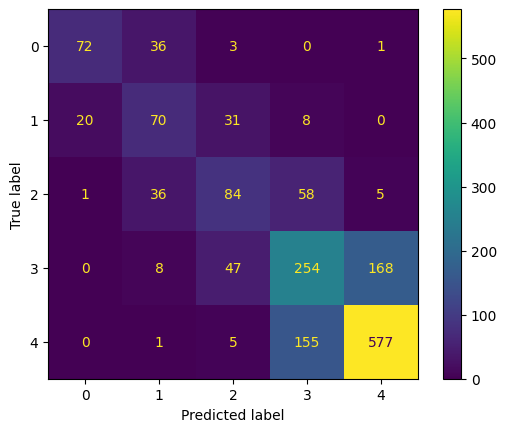

In [110]:
confusion_matrix_train = confusion_matrix(test_dataset.targets , predictions_argmax)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [111]:
mca_eval(predictions_argmax, torch.tensor(test_dataset.targets))

tensor([0.6429, 0.5426, 0.4565, 0.5325, 0.7818])

In [112]:
mca_average(predictions_argmax, torch.tensor(test_dataset.targets))

tensor(0.6445)

# SVM + TF-IDF

In [3]:
data = pd.read_csv("../data/train_data.csv")
data["label"] = data["rating"]
data.rename(columns={"review":"text"}, inplace=True)
data.drop('rating', axis=1, inplace=True)


In [4]:
reviews = data["text"]
label = data["label"]

In [5]:
vectorizer = TfidfVectorizer(
    min_df=5, max_features=16000, strip_accents='unicode', lowercase=True,
    analyzer='word', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, tokenizer=TweetTokenizer().tokenize, stop_words='english'
)
X = vectorizer.fit_transform(reviews)

/root/SSNE-Pawel/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.1, random_state=42)


In [167]:
clf = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='linear')

In [168]:
y_pred = clf.predict(X_test)

In [169]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report)
print(df)

                    0           1           2           3           4  \
precision    0.769231    0.471014    0.450450    0.517312    0.740420   
recall       0.625000    0.503876    0.271739    0.532495    0.811653   
f1-score     0.689655    0.486891    0.338983    0.524793    0.774402   
support    112.000000  129.000000  184.000000  477.000000  738.000000   

           accuracy    macro avg  weighted avg  
precision  0.632927     0.589686      0.623772  
recall     0.632927     0.548953      0.632927  
f1-score   0.632927     0.562945      0.624548  
support    0.632927  1640.000000   1640.000000  


In [170]:
accuracy_score(y_test, y_pred)

0.6329268292682927

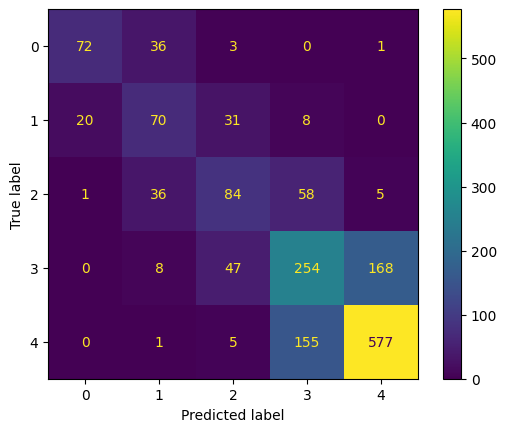

: 

In [171]:
confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [15]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [16]:
y_pred = clf.predict(X_test)

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report)
print(df)

                    0           1           2           3           4  \
precision    0.763158    0.461538    0.625000    0.411972    0.546549   
recall       0.517857    0.093023    0.027174    0.245283    0.922764   
f1-score     0.617021    0.154839    0.052083    0.307490    0.686492   
support    112.000000  129.000000  184.000000  477.000000  738.000000   

           accuracy    macro avg  weighted avg  
precision  0.532317     0.561643      0.524315  
recall     0.532317     0.361220      0.532317  
f1-score   0.532317     0.363585      0.458517  
support    0.532317  1640.000000   1640.000000  


In [18]:
accuracy_score(y_test, y_pred)

0.5323170731707317

In [20]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None],
    'class_weight':['balanced', None, 'balanced_subsample']
    
}

In [22]:
cv = GridSearchCV(rf,parameters)
cv.fit(X_train, y_train)

In [23]:
cv_results = cv.cv_results_

In [24]:
df = pd.DataFrame(cv_results)
print(df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.047219      0.002014         0.015260        0.000458   
1        0.217694      0.002511         0.040255        0.001864   
2        0.409343      0.005261         0.071774        0.007772   
3        0.102393      0.005773         0.015420        0.000368   
4        0.801351      0.010105         0.048487        0.004788   
5        1.589737      0.018746         0.081609        0.007292   
6        0.242185      0.019459         0.016209        0.000436   
7        2.311811      0.036959         0.052460        0.005309   
8        4.518989      0.050328         0.090383        0.003303   
9        1.309193      0.014460         0.018880        0.000660   
10      12.892660      0.082051         0.072341        0.005134   
11      25.827511      0.157441         0.143559        0.009544   
12       0.043161      0.000832         0.014937        0.000245   
13       0.213590      0.001246         0.041862

In [25]:
y_pred = clf.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.5323170731707317